# What factors most affect happiness?
##### Data Analysis for Udacity by Mateusz Mikulski

### Dataset Description

Gapminder took a global poll where participants were asked where, on a scale of 1 being the worst possible life and 10 being the best possible life, where they felt they personally landed at the time of asking. These responses were ranked by year and by national average response score.

This data can be located at https://www.gapminder.org/data/



The responses intrigued me, as some nations ranked higher than others, and wanted to see what correlations happiness had against other metrics. I will analyze the data against the following three other Gapminder data sets, as I want to see which of the following factors has the biggest effect on happiness.

Our three comparative factors:

#### Income - Mean household income
#### Life expectancy - the average number of years a newborn child would live
#### Gini - inequality coefficient (higher meaning more inequality)


### Data Wrangling

First, we will import and look at our raw data sets. Note, that the happiness index started being measured in 2004, and the other data sets go back much further. For the sake of this experiment, we will have to clean our supplemental data sets to only include data from 2020.

In [51]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats

happiness = pd.read_csv('happiness.csv', sep = ',')
incomeraw = pd.read_csv('income.csv', sep = ',')
lifeexpectancyraw = pd.read_csv('life_expectancy.csv', sep = ',')
giniraw = pd.read_csv('gini.csv', sep = ',')

happiness.head()

,country,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,NaN,NaN,NaN,37.2,44.0,47.6,38.3,37.8,35.7,31.3,39.8,42.2,26.6,26.9,23.8,NaN,24.0
1,Angola,NaN,NaN,NaN,NaN,NaN,NaN,55.9,43.6,39.4,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,NaN,NaN,46.3,NaN,54.9,52.7,58.7,55.1,45.5,48.1,46.1,45.1,46.4,50.0,50.0,53.6,52.0
3,United Arab Emirates,NaN,67.3,NaN,NaN,68.7,71.0,71.2,72.2,66.2,65.4,65.7,68.3,70.4,66.0,67.1,64.6,65.8
4,Argentina,NaN,63.1,60.7,59.6,64.2,64.4,67.8,64.7,65.8,66.7,67.0,64.3,60.4,57.9,60.9,59.0,59.7


### Data cleanup:
We have to clean up our data sets, since we will *only* want to look at data from 2020 for each metric, and compare our metrics against each other. In this phase, we are making all of our datasets the same length horizontally.

In [52]:
happiness = happiness.iloc[:, np.r_[0, 17:18]] #snipping excess dates from dataframe, keeping only '2020'
happiness.head()

,country,2020
0,Afghanistan,24.0
1,Angola,NaN
2,Albania,52.0
3,United Arab Emirates,65.8
4,Argentina,59.7


We'll also be changing the '2020' column to the name of the data set we are working with and shorten our dataframe names.

In [53]:
h = happiness.rename(columns = {'2020':'happiness'})
h.set_index('country')
gini = giniraw.iloc[:, np.r_[0, 222:223]]
g = gini.rename(columns = {'2020':'gini'})
g.set_index('country')
income = incomeraw.iloc[:, np.r_[0, 222:223]]
i = income.rename(columns = {'2020':'income'})
i.set_index('country')
lifeexpectancy = lifeexpectancyraw.iloc[:, np.r_[0, 222:223]]
l = lifeexpectancy.rename(columns = {'2020':'life expectancy'})
l.set_index('country')

l.head(10)

,country,life expectancy
0,Afghanistan,64.0
1,Angola,65.8
2,Albania,78.7
3,Andorra,NaN
4,United Arab Emirates,74.2
5,Argentina,76.9
6,Armenia,76.0
7,Antigua and Barbuda,76.5
8,Australia,83.2
9,Austria,82.4


I noticed that the 'income' data set has values of thousand in k. 

In [54]:
income.head()

,country,2020
0,Afghanistan,1970
1,Angola,1520
2,Albania,3560
3,United Arab Emirates,35.3k
4,Argentina,12.1k


To fix this, we will create a <b>function</b> that finds and converts these values of k to 1000, and multiplies it properly:

In [55]:
def k_converter(x):
    y = 0
    conversion = {'K':1000, 'k':1000}
    if x != 'na':
        x = str(x)
    if x.isdigit():
        y = int(x)
    else:
        if len(x) > 1:
            y = float(x[:-1]) * conversion.get(x[-1].upper(), 1)
    return int(y)

i['income'] = i['income'].map(k_converter)

i.head(10)

,country,income
0,Afghanistan,1970
1,Angola,1520
2,Albania,3560
3,United Arab Emirates,35300
4,Argentina,12100
5,Armenia,2850
6,Antigua and Barbuda,12000
7,Australia,22800
8,Austria,20800
9,Azerbaijan,4830


Just to be safe, and to have a record of our modified income datatable, lets export this as a seperate CSV and reupload it.

In [56]:
i.to_csv('cleaned_income.csv', index=False)
i2 = pd.read_csv('cleaned_income.csv', sep = ',')
i2.head()

,country,income
0,Afghanistan,1970
1,Angola,1520
2,Albania,3560
3,United Arab Emirates,35300
4,Argentina,12100


### Appending Data:
Now, we will want to merge all of data into one dataframe. I do this with a series of joins. We will call this combined dataframe 'metrics.' I then export the file for safekeeping.

In [57]:
j1 = pd.merge(h,i2, on ='country',how='right')
j2 = pd.merge(j1,l, on ='country',how='right')
j3 = pd.merge(j2,g, on ='country',how='right')

metrics = j3
metrics.to_csv('sorted_gapminder_metrics.csv', index=False)
metrics.head(100)

,country,happiness,income,life expectancy,gini
0,Afghanistan,24.0,1970.0,64.0,39.0
1,Angola,NaN,1520.0,65.8,53.0
2,Albania,52.0,3560.0,78.7,34.5
3,Andorra,NaN,NaN,NaN,35.0
4,United Arab Emirates,65.8,35300.0,74.2,26.7
...,...,...,...,...,...
95,South Korea,59.4,17600.0,83.2,32.1
96,Kuwait,61.1,17300.0,81.7,36.1
97,Lao,51.4,2210.0,69.6,38.8
98,Lebanon,29.6,7160.0,76.8,33.1


### Exploratory Data Analysis
Now, let's make some simple graphs to see if there is a general correlation between income, life expectancy, and inequality. 

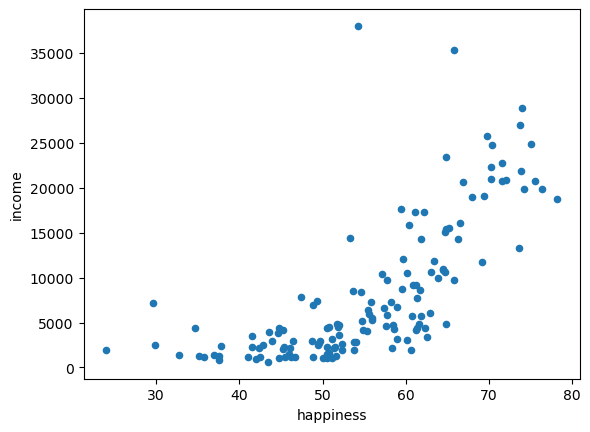

In [58]:
metrics.plot(x='happiness', y='income', kind="scatter");

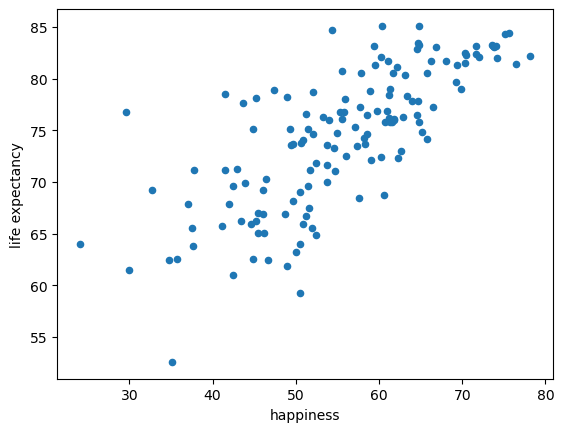

In [59]:
metrics.plot(x='happiness', y='life expectancy', kind="scatter");

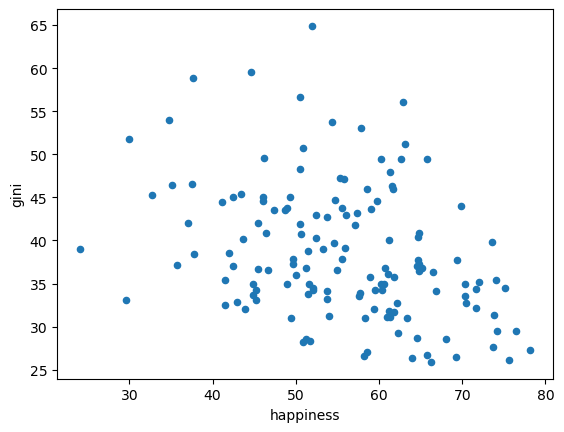

In [60]:
metrics.plot(x='happiness', y='gini', kind="scatter");

It looks like there definitely is a positive correlation between income, life expectancy, gini, and happiness. Notice that because our GINI coefficient is measured with a high number meaning high inequality, this data set creates a bit of a inverted correlation.

### Research question - which correlation is the <i>strongest</i>?

In the next cell, we will get our dataframes ready for some deeper analysis. To find which correlation is the strongest, we will need to find the R coefficient of each scatterplot. To find things such as the R value of a dataset, the arrays must be the same size. For the sake of this, we will be stripping out any NaN or Null values:

In [72]:
m = metrics.dropna()
m.head()

,country,happiness,income,life expectancy,gini
0,Afghanistan,24.0,1970.0,64.0,39.0
2,Albania,52.0,3560.0,78.7,34.5
4,United Arab Emirates,65.8,35300.0,74.2,26.7
5,Argentina,59.7,12100.0,76.9,44.6
6,Armenia,54.0,2850.0,76.0,31.2


Below, we will find the R coefficient of the 3 data types and use them to make lines, to see which value has the highest correl;ation with happiness.

In [154]:
import scipy.stats
hi = scipy.stats.linregress(m['happiness'], m['income'])
hl = scipy.stats.linregress(m['happiness'], m['life expectancy'])
hg = scipy.stats.linregress(m['happiness'], m['gini'])
ir2 = hi.rvalue
lr2 = hl.rvalue
gr2 = hg.rvalue * -1 #because our GINI correlation would be high-to-low by default

print(ir2,lr2,gr2)

0.7181659617277288 0.7480646123968937 0.3537148343351587


Finally, we will append some line plots on top of our scatter chart to visualize the correlations.

While I am still a beginner in data science and rusty in my statistics skills, I believe I have enough data available to at least answer our research question.

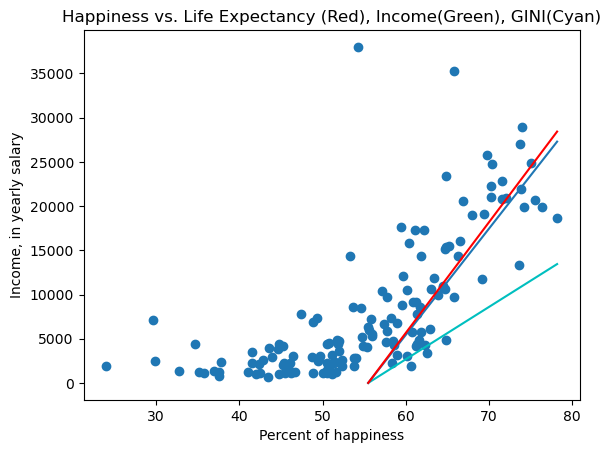

In [156]:
#finding parameters of scale for line plots
from statistics import mean
meanh = mean(m['happiness'])
maxh = max(m['happiness'])
maxi = max(m['income'])

plt.title('Happiness vs. Life Expectancy (Red), Income(Green), GINI(Cyan)')
plt.xlabel('Percent of happiness')
plt.ylabel('Income, in yearly salary')
x1 = np.linspace(meanh, maxh, 50) #linspace to extend our lines
y1 = np.linspace(0, gr2*maxi, 50)
plt.plot(x1, y1, c = 'c')  
x1 = np.linspace(meanh, maxh, 50)
y1 = np.linspace(0, ir2*maxi, 50)
plt.plot(x1, y1)
x1 = np.linspace(meanh, maxh, 50)
y1 = np.linspace(0, lr2*maxi, 50)
plt.plot(x1, y1, c = 'r') 
plt.scatter(m['happiness'], m['income'])
plt.show()

### Conclusions
The above graph does enough to answer the question of, which factor affects happiness the most. Life Expectancy narrowly takes the crown!

In my first purview of the data, I had originally predicted income to be the largest driver of happiness globally, not from any biases but from my first few glances over the data, where countries with vastly higher income did indeed have higher scores.

That being said, there are many outliers. Japan, for instance, measures highly in every statistic <i>except</i> happiness.

In [179]:
print(m.iloc[['52']])
print(m.iloc[['59']])
print(m.iloc[['64']])

    country  happiness  income  life expectancy  gini
75  Croatia       61.3  7740.0             79.0  31.1
    country  happiness   income  life expectancy  gini
83  Iceland       75.6  20700.0             84.4  26.1
   country  happiness   income  life expectancy  gini
88   Japan       60.4  15800.0             85.1  34.3


Additionally, I believed that inequality would have had a larger impact than life expectancy, but I suppose regardless of your neighbor's health, you have to be alive to be happy.

In conclusion, these many outliers made this data impossible to analyze with the naked eye and required mathematical correlations to solve our research question, and now we know that life expectancy is one of the biggest drivers of global happiness. Thanks for checking out my project! - Matt